# Non Stationary LSTM

주가처럼 그래프 자체만으로는 random walk수준의 그래프 이지만, 외부변수를 줌으로서 LSTM이 어떻게 예측을 할 수 있는지 테스트

In [1]:
%pylab inline
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.activations import relu
from keras.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot

np.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


## Data

data x shape: (30000, 50, 6)
data y shape: (30000, 50, 1)


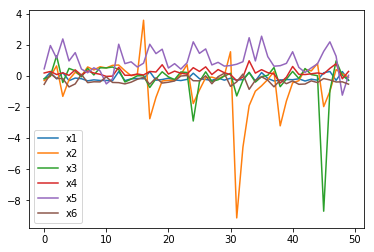

In [2]:
BATCH_SIZE=30000
TIME_SERIES_LENGTH = 50
OUTSIDE_VAR_COUNT = 6

# 요일 이펙트
def d1(x):
    return 1/(np.e * (x+0.023))

def d2(x):
    return -1/(x+0.02)

def d3(x):
    return 1/(x + 1.7)

def d4(x):
    return 2 + x/10

def d5(x):
    return  np.log(1/abs(x)) *  x

def create_data(batch_size=1000, time_series_length=500, moving_avg_n=1):
    funcs = [np.sin, np.cos, d1, d2, d3, d4, d5]
    func_count = len(funcs)
    
    x_data = np.zeros((batch_size, time_series_length, OUTSIDE_VAR_COUNT))
    y_data = np.zeros((batch_size, time_series_length, 1))

    for batch_idx in range(batch_size):
        ts_x = np.zeros((time_series_length, OUTSIDE_VAR_COUNT), dtype=np.float16)
        ts_y = np.zeros((time_series_length, 1))
        
        y1_prev, y2_prev, y3_prev, y4_prev, y5_prev, y6_prev = (0, 0, 0, 0, 0, 0)
        
        t = 0
        while t < time_series_length:
            x1 = np.random.rand(1)
            x2 = np.random.rand(1) * 0.1
            x3 = np.random.rand(1) * 0.5
            x4 = np.random.rand(1) * 1.2 + 0.5
            x5 = np.random.rand(1) * 1.5 + 2
            x6 = np.random.randn(1)
            
            if x1 > 0.8:
                x1 *= 2 + 0.5
                x2 *= 1.3 + 0.2
                x3 *= 0.5 + 1
                x4 *= 0.1 + 2
                x5 *= 1.5 + 1.2
            
            if x1 < 0.2:
                x2 += 2
                x3 += 3
                x4 = 1/x4
                x5 = 1/x5
                
            ts_x[t, 0] = x1
            ts_x[t, 1] = funcs[t%func_count](x2) + x2 + y2_prev * 0.5
            ts_x[t, 2] = funcs[t%func_count](x3) + x3 + y3_prev * 0.1
            ts_x[t, 3] = funcs[t%func_count](x4) + x4 + y4_prev * 0.2
            ts_x[t, 4] = funcs[t%func_count](x5) + x5 + y5_prev * 0.4
            ts_x[t, 5] = x6 + y6_prev * 0.1
            ts_y[t, 0] = funcs[t%func_count](x1) + x1 + y1_prev * 0.3
            y1_prev, y2_prev, y3_prev, y4_prev, y5_prev, y6_prev = ts_x[t].tolist()
            
            if np.isinf(ts_x[t]).any() or np.isnan(ts_x[t]).any():
                print('haha', ts_x[t], y5_prev)
                continue
            t += 1
            
        x_data[batch_idx, :] = ts_x
        y_data[batch_idx, :] = ts_y
    return x_data, y_data
    
data_x, data_y = create_data(batch_size=BATCH_SIZE, 
                             time_series_length=TIME_SERIES_LENGTH)


# Scaling X
x_shape = data_x.shape
scaler_x = StandardScaler()
data_x = scaler_x.fit_transform(data_x.reshape(-1, 1))
data_x = data_x.reshape(x_shape)

plot(data_x[0, :, 0], label='x1')
plot(data_x[0, :, 1], label='x2')
plot(data_x[0, :, 2], label='x3')
plot(data_x[0, :, 3], label='x4')
plot(data_x[0, :, 4], label='x5')
plot(data_x[0, :, 5], label='x6')
legend()

# Scaling Y
y_shape = data_y.shape
scaler_y = StandardScaler()
data_y = scaler_y.fit_transform(data_y.reshape(-1, 1))
data_y = data_y.reshape(y_shape)

# Split
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2, random_state=0)

print('data x shape:', data_x.shape)
print('data y shape:', data_y.shape)

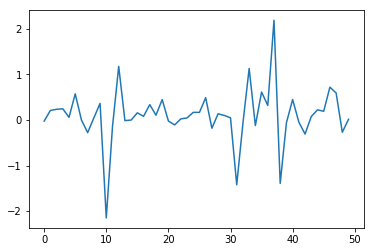

In [3]:
plot(data_y[0], label='y')

In [5]:
np.savetxt('train_x.txt', train_x.reshape(-1, OUTSIDE_VAR_COUNT), delimiter=',')
np.savetxt('train_y.txt', train_y.reshape(-1, 1), delimiter=',')
np.savetxt('test_x.txt', test_x.reshape(-1, OUTSIDE_VAR_COUNT), delimiter=',')
np.savetxt('test_y.txt', test_y.reshape(-1, 1), delimiter=',')

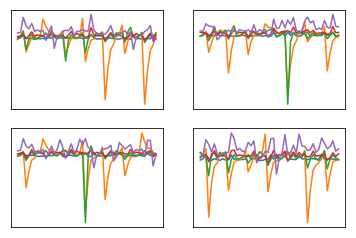

In [6]:
def visualize(data_x, data_y):
    fig, sub_plots = subplots(2, 2)
    for columns in sub_plots:
        for sp in columns:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
                        
            batch_idx = np.random.randint(data_x.shape[0])
            sample_x = data_x[batch_idx]
#             sample_y = data_y[batch_idx]
                                    
            sample_x1 = sample_x[:, 0]
            sample_x2 = sample_x[:, 1]
            sample_x3 = sample_x[:, 2]
            sample_x4 = sample_x[:, 3]
            sample_x5 = sample_x[:, 4]
        
            tick_x = range(sample_x.shape[0])
            
            sp.plot(tick_x, sample_x1, label='x1')
            sp.plot(tick_x, sample_x2, label='x2')
            sp.plot(tick_x, sample_x3, label='x3')
            sp.plot(tick_x, sample_x4, label='x4')
            sp.plot(tick_x, sample_x5, label='x5')
            
visualize(data_x, data_y)

## Model

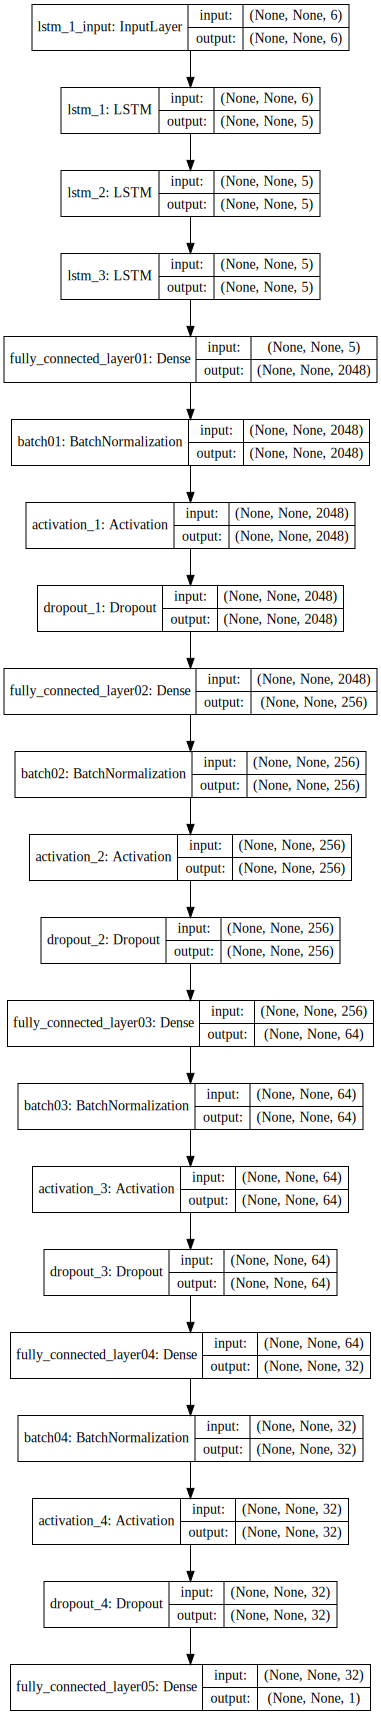

In [7]:
def create_model(lstm_out1=5, lstm_out2=5, lstm_out3=5, dense1=2048, dense2=256, dense3=64, dense4=32, 
                 optimizer='adam'):
    model = Sequential(name='lstm')
    model.add(LSTM(lstm_out1, batch_input_shape=(None, None, OUTSIDE_VAR_COUNT), return_sequences=True))
    if lstm_out2 is not None:
        model.add(LSTM(lstm_out2, return_sequences=True))
    
    if lstm_out3 is not None:
        model.add(LSTM(lstm_out3, return_sequences=True))
    
    model.add(Dense(dense1, name='fully_connected_layer01'))
    model.add(BatchNormalization(name='batch01'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(dense2, name='fully_connected_layer02'))
    model.add(BatchNormalization(name='batch02'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(dense3, name='fully_connected_layer03'))
    model.add(BatchNormalization(name='batch03'))
    model.add(Activation('relu'))
    model.add(Dropout(0.))
    
    model.add(Dense(dense4, name='fully_connected_layer04'))
    model.add(BatchNormalization(name='batch04'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, name='fully_connected_layer05'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[mean_squared_error])
    return model
model = create_model()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Training

In [11]:
model = create_model(lstm_out1=200, lstm_out2=170, lstm_out3=None, dense1=2560, dense2=1536, dense3=512, 
                     dense4=256)
model.fit(train_x, train_y, verbose=2, epochs=2000)

Epoch 1/2000
89s - loss: 0.4418 - mean_squared_error: 0.4418
Epoch 2/2000
88s - loss: 0.1174 - mean_squared_error: 0.1174
Epoch 3/2000
89s - loss: 0.0749 - mean_squared_error: 0.0749
Epoch 4/2000
88s - loss: 0.0579 - mean_squared_error: 0.0579
Epoch 5/2000
89s - loss: 0.0537 - mean_squared_error: 0.0537
Epoch 6/2000
88s - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 7/2000
88s - loss: 0.0455 - mean_squared_error: 0.0455
Epoch 8/2000
88s - loss: 0.0394 - mean_squared_error: 0.0394
Epoch 9/2000
89s - loss: 0.0416 - mean_squared_error: 0.0416
Epoch 10/2000
88s - loss: 0.0395 - mean_squared_error: 0.0395
Epoch 11/2000
88s - loss: 0.0369 - mean_squared_error: 0.0369
Epoch 12/2000
88s - loss: 0.0327 - mean_squared_error: 0.0327
Epoch 13/2000
88s - loss: 0.0314 - mean_squared_error: 0.0314
Epoch 14/2000
89s - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 15/2000
88s - loss: 0.0300 - mean_squared_error: 0.0300
Epoch 16/2000
88s - loss: 0.0270 - mean_squared_error: 0.0270
Epoch 17/2000
88s

87s - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 134/2000
87s - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 135/2000
87s - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 136/2000
87s - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 137/2000
87s - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 138/2000
87s - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 139/2000
87s - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 140/2000
87s - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 141/2000
87s - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 142/2000
87s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 143/2000
87s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 144/2000
87s - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 145/2000
87s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 146/2000
87s - loss: 0.0086 - mean_squared_error: 0.0086
Epoch 147/2000
87s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 148/2000
87s - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 1

87s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 265/2000
87s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 266/2000
87s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 267/2000
87s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 268/2000
87s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 269/2000
87s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 270/2000
87s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 271/2000
87s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 272/2000
87s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 273/2000
87s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 274/2000
87s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 275/2000
87s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 276/2000
87s - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 277/2000
87s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 278/2000
87s - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 279/2000
87s - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 2

87s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 396/2000
87s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 397/2000
88s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 398/2000
87s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 399/2000
87s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 400/2000
87s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 401/2000
87s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 402/2000
87s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 403/2000
87s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 404/2000
87s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 405/2000
87s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 406/2000
87s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 407/2000
87s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 408/2000
87s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 409/2000
87s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 410/2000
87s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 4

87s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 527/2000
87s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 528/2000
87s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 529/2000
87s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 530/2000
88s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 531/2000
87s - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 532/2000
87s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 533/2000
87s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 534/2000
87s - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 535/2000
87s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 536/2000
88s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 537/2000
87s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 538/2000
87s - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 539/2000
87s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 540/2000
88s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 541/2000
87s - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 5

87s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 658/2000
88s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 659/2000
88s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 660/2000
87s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 661/2000
87s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 662/2000
87s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 663/2000
87s - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 664/2000
88s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 665/2000
88s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 666/2000
87s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 667/2000
88s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 668/2000
87s - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 669/2000
87s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 670/2000
88s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 671/2000
87s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 672/2000
87s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 6

88s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 789/2000
87s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 790/2000
88s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 791/2000
87s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 792/2000
88s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 793/2000
88s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 794/2000
88s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 795/2000
88s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 796/2000
88s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 797/2000
87s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 798/2000
88s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 799/2000
88s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 800/2000
88s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 801/2000
87s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 802/2000
88s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 803/2000
87s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 8

88s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 920/2000
87s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 921/2000
87s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 922/2000
87s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 923/2000
87s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 924/2000
87s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 925/2000
87s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 926/2000
88s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 927/2000
87s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 928/2000
87s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 929/2000
88s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 930/2000
87s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 931/2000
87s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 932/2000
87s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 933/2000
87s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 934/2000
87s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 9

87s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 1050/2000
87s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 1051/2000
87s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1052/2000
88s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 1053/2000
87s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1054/2000
87s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1055/2000
87s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 1056/2000
87s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 1057/2000
88s - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 1058/2000
88s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 1059/2000
87s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 1060/2000
87s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 1061/2000
87s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 1062/2000
87s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 1063/2000
87s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1064/2000
87s - loss: 0.0044 - mean_squared_error:

87s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 1179/2000
87s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 1180/2000
87s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 1181/2000
87s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1182/2000
87s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1183/2000
87s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 1184/2000
87s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 1185/2000
87s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 1186/2000
87s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 1187/2000
87s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1188/2000
87s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 1189/2000
87s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 1190/2000
87s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1191/2000
87s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 1192/2000
87s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1193/2000
87s - loss: 0.0041 - mean_squared_error:

87s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 1308/2000
87s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 1309/2000
87s - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 1310/2000
87s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 1311/2000
87s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 1312/2000
87s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 1313/2000
87s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 1314/2000
87s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1315/2000
87s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1316/2000
87s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 1317/2000
87s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 1318/2000
86s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 1319/2000
87s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 1320/2000
87s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1321/2000
87s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 1322/2000
87s - loss: 0.0041 - mean_squared_error:

87s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 1437/2000
87s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1438/2000
87s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1439/2000
86s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 1440/2000
87s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1441/2000
87s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 1442/2000
87s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1443/2000
87s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 1444/2000
87s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1445/2000
86s - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 1446/2000
86s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1447/2000
87s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 1448/2000
86s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 1449/2000
87s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 1450/2000
86s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1451/2000
87s - loss: 0.0040 - mean_squared_error:

87s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1566/2000
86s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1567/2000
86s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1568/2000
87s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1569/2000
87s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1570/2000
86s - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 1571/2000
87s - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 1572/2000
87s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1573/2000
86s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1574/2000
87s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1575/2000
87s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 1576/2000
87s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1577/2000
87s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 1578/2000
87s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1579/2000
87s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1580/2000
87s - loss: 0.0040 - mean_squared_error:

87s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 1695/2000
87s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1696/2000
87s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1697/2000
87s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1698/2000
87s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1699/2000
87s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 1700/2000
87s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1701/2000
87s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1702/2000
87s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1703/2000
88s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1704/2000
87s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1705/2000
87s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1706/2000
87s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1707/2000
87s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1708/2000
87s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1709/2000
87s - loss: 0.0040 - mean_squared_error:

88s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1824/2000
87s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 1825/2000
87s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1826/2000
87s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 1827/2000
87s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 1828/2000
87s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1829/2000
87s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1830/2000
87s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 1831/2000
87s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1832/2000
88s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 1833/2000
88s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 1834/2000
88s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1835/2000
88s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1836/2000
87s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1837/2000
88s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1838/2000
87s - loss: 0.0037 - mean_squared_error:

87s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1953/2000
87s - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 1954/2000
88s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 1955/2000
87s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1956/2000
87s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1957/2000
87s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1958/2000
87s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1959/2000
87s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 1960/2000
87s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 1961/2000
87s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1962/2000
88s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1963/2000
87s - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 1964/2000
88s - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 1965/2000
87s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1966/2000
87s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1967/2000
87s - loss: 0.0036 - mean_squared_error:

error:0.010265225137652836, score:0.9893148514306189
score: 0.989314851431


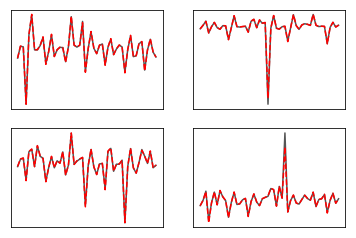

In [18]:
def accuracy(y_true, y_pred):
    y_true = y_true.reshape((-1, 1))
    y_pred = y_pred.reshape((-1, 1))
    score = r2_score(y_true, y_pred, multioutput='variance_weighted')
    error = ((y_true - y_pred)**2).mean()
    print(f'error:{error}, score:{score}')
    return score


def visualize_prediction(data_x, data_y):
    pred_y = model.predict(data_x)
    
    print('score:', accuracy(data_y, pred_y))
    
    fig, sub_plots = subplots(2, 2)
    
    for col_plots in sub_plots:
        for sp in col_plots:
            sp.get_xaxis().set_visible(False)
            sp.get_yaxis().set_visible(False)
            
            idx = np.random.randint(data_x.shape[0])
            sp.plot(data_y[idx], color='#555555')
            sp.plot(pred_y[idx], color='red', linestyle='--')

visualize_prediction(test_x, test_y)

In [19]:
model.save('model.h5')

# Test

### test1

```
model = create_model(lstm_out1=200, lstm_out2=170, lstm_out3=None, dense1=2560, dense2=1536, 
                     dense3=512,dense4=256)
model.fit(train_x, train_y, verbose=2, epochs=2000)

error:0.010265225137652836, score:0.9893148514306189
score: 0.989314851431
```